# DSA4212 Assignment 2
**CAA: 7 April 2023**

## Imports

In [1]:
!pip install jaxopt surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

# Suppress warnings
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as onp
from tqdm.auto import tqdm
import pylab as plt
import copy
import time
from random import sample
import random
from collections import defaultdict
import pandas as pd
import jax, jaxopt
import jax.numpy as jnp
import scipy as sp
from sklearn.metrics import mean_squared_error
import operator
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

In [3]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive

    !nvidia-smi -L
    !lscpu |grep 'Model name'
    !free -h --si | awk  '/Mem:/{print $2}'

GPU 0: Tesla T4 (UUID: GPU-d286ddd2-ec97-dcad-6406-1bab2f24d911)
Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
12G


## Load Data
Serializes user IDs to `uid2idx` and anime IDs to `aid2idx`

In [4]:
if 'google.colab' in str(get_ipython()):
    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/dataset/DSA4212/assignment_2/

anime = pd.read_csv("assignment_2_anime.csv")
train = pd.read_csv("assignment_2_ratings_train.csv")
test = pd.read_csv("assignment_2_ratings_test.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/dataset/DSA4212/assignment_2


In [5]:
grouped_anime = train.groupby("anime_id", as_index=False).agg({"rating": [onp.sum, len, onp.mean]})
grouped_anime = pd.concat([grouped_anime.anime_id, grouped_anime.rating], axis=1)
grouped_anime.head()

,anime_id,sum,len,mean
0,1,82597,9314,8.868048
1,5,34234,4058,8.436175
2,6,55853,6629,8.425554
3,7,11142,1488,7.487903
4,8,1601,224,7.147321


In [6]:
grouped_user = train.groupby("user_id", as_index=False).agg({"rating": [onp.sum, len, onp.mean]})
grouped_user = pd.concat([grouped_user.user_id, grouped_user.rating], axis=1)
grouped_user.head()

,user_id,sum,len,mean
0,1,30,3,10.000000
1,3,474,64,7.406250
2,5,1416,318,4.452830
3,7,1739,237,7.337553
4,8,46,6,7.666667


In [7]:
uid2idx = {e:i for i,e in enumerate(sorted(set(grouped_user.user_id) | set(test.user_id)))}
aid2idx = {e:i for i,e in enumerate(sorted(set(grouped_anime.anime_id) | set(test.anime_id)))}
len(uid2idx), len(aid2idx)

(69600, 9927)

## Baseline

In [8]:
train_rating_matrix = onp.zeros(shape=(len(uid2idx), len(aid2idx)))
for _, (uid, aid, rating) in tqdm(train.iterrows()):
    train_rating_matrix[uid2idx[uid]][aid2idx[aid]] = rating
train_rating_matrix = train_rating_matrix.astype(onp.float32)

0it [00:00, ?it/s]

In [9]:
test_rating_matrix = onp.zeros(shape=(len(uid2idx), len(aid2idx)))
for _, (uid, aid, rating) in tqdm(test.iterrows()):
    test_rating_matrix[uid2idx[uid]][aid2idx[aid]] = rating
test_rating_matrix = test_rating_matrix.astype(onp.float32)

0it [00:00, ?it/s]

## Latent Factor Model w/o SVD

In [10]:
# Split U x A to U x r and A x r
r = 3

# supplier
user_weights_init = lambda: onp.random.normal(0,1,size=(len(uid2idx), r)).astype(onp.float32)
anime_weights_init = lambda: onp.random.normal(0,1,size=(len(aid2idx), r)).astype(onp.float32)

In [11]:
indices = onp.where(train_rating_matrix != 0)
test_indices = onp.where(test_rating_matrix != 0)
train_ratings = train_rating_matrix[indices]
test_ratings = test_rating_matrix[test_indices]

In [12]:
@jax.jit
def MSE(WU, WA):
    error = train_ratings - (WU @ WA.T)[indices]
    return jnp.mean(error**2)
MSE_grad_u = jax.jit(jax.grad(MSE, argnums=0))
MSE_grad_a = jax.jit(jax.grad(MSE, argnums=1))

In [13]:
@jax.jit
def MSE_test(WU, WA):
    error = test_ratings - (WU @ WA.T)[test_indices]
    return jnp.mean(error**2)

### Gradient Descent

#### Sequential

In [54]:
WU, WA = user_weights_init(), anime_weights_init()
train_mse_hist = [MSE(WU, WA)]
test_mse_hist = [MSE_test(WU, WA)]

niter = 4000
learning_rate = 40

In [55]:
%%time
for _ in tqdm(range(niter)):
    grad_u = MSE_grad_u(WU, WA)
    WU = WU - learning_rate*grad_u

    grad_a = MSE_grad_a(WU, WA)
    WA = WA - learning_rate*grad_a

    train_mse_hist.append(MSE(WU, WA))
    test_mse_hist.append(MSE_test(WU, WA))

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 14.1 s, sys: 2.04 s, total: 16.1 s
Wall time: 9min 27s


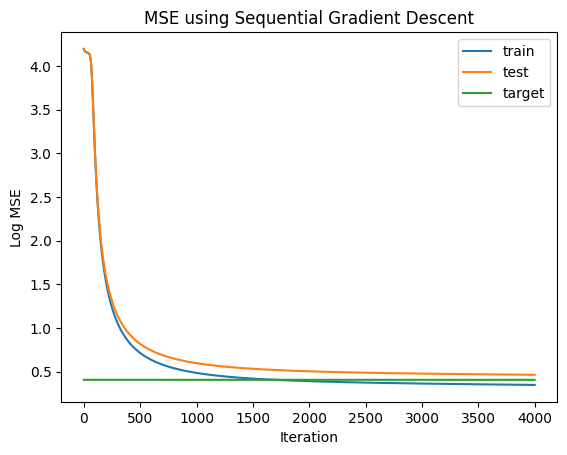

In [56]:
plt.plot(onp.log(train_mse_hist), label='train')
plt.plot(onp.log(test_mse_hist), label='test')
plt.plot([onp.log(1.5)]*niter, label='target')
plt.title('MSE using Sequential Gradient Descent')
plt.xlabel('Iteration')
plt.ylabel('Log MSE')
plt.legend()
plt.show()

In [57]:
test_mse_hist[-20:]

[Array(1.5892152, dtype=float32),
 Array(1.5891973, dtype=float32),
 Array(1.5891794, dtype=float32),
 Array(1.5891614, dtype=float32),
 Array(1.5891435, dtype=float32),
 Array(1.5891256, dtype=float32),
 Array(1.5891076, dtype=float32),
 Array(1.5890898, dtype=float32),
 Array(1.5890719, dtype=float32),
 Array(1.589054, dtype=float32),
 Array(1.5890361, dtype=float32),
 Array(1.5890182, dtype=float32),
 Array(1.5890003, dtype=float32),
 Array(1.5889825, dtype=float32),
 Array(1.5889645, dtype=float32),
 Array(1.5889466, dtype=float32),
 Array(1.5889287, dtype=float32),
 Array(1.588911, dtype=float32),
 Array(1.5888932, dtype=float32),
 Array(1.5888754, dtype=float32)]

#### Parallel

In [58]:
WU, WA = user_weights_init(), anime_weights_init()
train_mse_hist = [MSE(WU, WA)]
test_mse_hist = [MSE_test(WU, WA)]

niter = 4000
learning_rate = 35

In [59]:
%%time
for _ in tqdm(range(niter)):
    grad_u = MSE_grad_u(WU, WA)
    grad_a = MSE_grad_a(WU, WA)
    WU, WA = WU - learning_rate*grad_u, WA - learning_rate*grad_a
    train_mse_hist.append(MSE(WU, WA))
    test_mse_hist.append(MSE_test(WU, WA))

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 15.3 s, sys: 2.16 s, total: 17.4 s
Wall time: 9min 27s


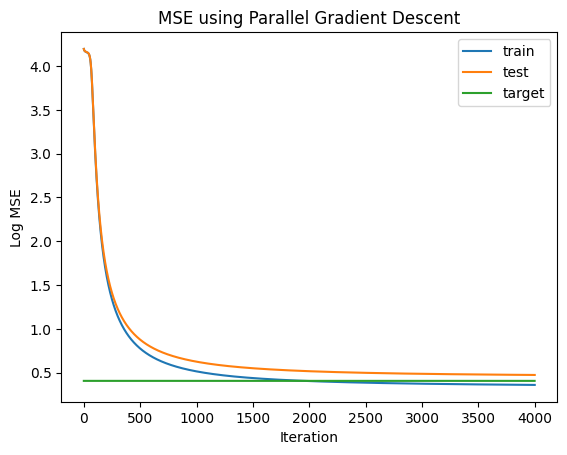

In [60]:
plt.plot(onp.log(train_mse_hist), label='train')
plt.plot(onp.log(test_mse_hist), label='test')
plt.plot([onp.log(1.5)]*niter, label='target')
plt.title('MSE using Parallel Gradient Descent')
plt.xlabel('Iteration')
plt.ylabel('Log MSE')
plt.legend()
plt.show()

In [61]:
test_mse_hist[-20:]

[Array(1.605039, dtype=float32),
 Array(1.6050241, dtype=float32),
 Array(1.605009, dtype=float32),
 Array(1.604994, dtype=float32),
 Array(1.6049792, dtype=float32),
 Array(1.6049643, dtype=float32),
 Array(1.6049492, dtype=float32),
 Array(1.6049345, dtype=float32),
 Array(1.6049194, dtype=float32),
 Array(1.6049047, dtype=float32),
 Array(1.6048898, dtype=float32),
 Array(1.6048747, dtype=float32),
 Array(1.60486, dtype=float32),
 Array(1.604845, dtype=float32),
 Array(1.6048301, dtype=float32),
 Array(1.6048152, dtype=float32),
 Array(1.6048005, dtype=float32),
 Array(1.6047857, dtype=float32),
 Array(1.6047708, dtype=float32),
 Array(1.604756, dtype=float32)]

### L-BFGS

In [30]:
@jax.jit
def extract(param):
    user_weights = param[:(len(uid2idx)*r)]
    anime_weights = param[(len(uid2idx)*r):]
    return user_weights.reshape(len(uid2idx), r), anime_weights.reshape(len(aid2idx), r)

def MSE_lbfgs(params):
    WU, WA = extract(params)
    error = train_ratings - (WU @ WA.T)[indices]
    return onp.mean(error**2)

@jax.jit
def MSE_test_lbfgs(params):
    WU, WA = extract(params)
    error = test_ratings - (WU @ WA.T)[test_indices]
    return jnp.mean(error**2)

MSE_lbfgs_grad = jax.jit(jax.grad(MSE_lbfgs))

In [45]:
param_init = onp.concatenate([
    user_weights_init().ravel(),
    anime_weights_init().ravel()]).astype(onp.float32)

In [44]:
def gradient_wrapper(x):
    return onp.array(MSE_lbfgs_grad(x))

loss_history = []
time_history = []

def save_traj(beta):
    """ a function that saves a few statistics for later analysis"""
    loss_history.append(MSE_lbfgs(beta))
    time_history.append(time.time() - start)

In [46]:
start = time.time()
traj = sp.optimize.minimize(fun = MSE_lbfgs,
                            x0 = param_init,
                            method='L-BFGS-B',
                            jac=gradient_wrapper,
                            callback=save_traj,
                            options={"maxiter":1000})

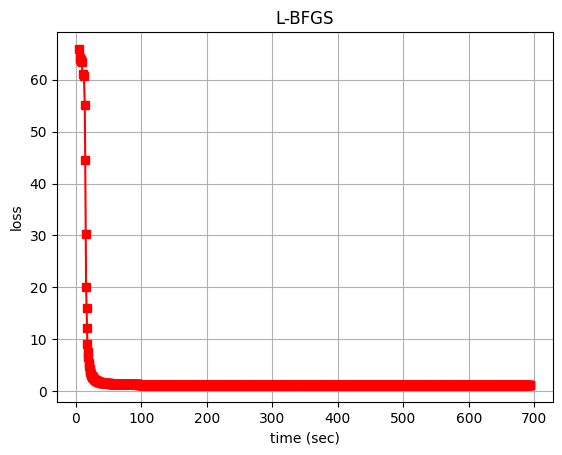

In [47]:
plt.plot(time_history, loss_history, "r-s")
plt.xlabel("time (sec)")
plt.ylabel("loss")
plt.title("L-BFGS")
plt.grid(True)

In [48]:
MSE_test_lbfgs(traj.x)

Array(1.4763475, dtype=float64)

## Using Surprise for Item-Based Collaborative Filtering

In [13]:
from surprise import Dataset, Reader, SVD, SVDpp, accuracy
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline

similarity = {
    "name": "cosine",
    "user_based": False,
}
algo_KNN_basic = KNNBasic(sim_options=similarity)
algo_KNN_means = KNNWithMeans(sim_options=similarity)
algo_KNN_zscore = KNNWithZScore(sim_options=similarity)
algo_KNN_baseline = KNNBaseline(sim_options=similarity)

In [16]:
reader = Reader(rating_scale=(1, 10))
rating_train_df = Dataset.load_from_df(train, reader)
rating_train_df = rating_train_df.build_full_trainset()
rating_test_df = Dataset.load_from_df(test, reader)
rating_test_df = rating_test_df.build_full_trainset().build_testset()

In [17]:
for algo in [algo_KNN_basic, algo_KNN_means, algo_KNN_zscore, algo_KNN_baseline]:
    algo.fit(rating_train_df)
    test_out = algo.test(rating_test_df)
    print(type(algo).__name__, accuracy.mse(test_out, verbose=False))

Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNBasic 1.682647210823903
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNWithMeans 1.4139614611458935
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNWithZScore 1.4129900258128265
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNNBaseline 1.405066379135643
